# 【視覺化/互動VAE中手寫辨識的Decoder】

#### 組員:
* B03207062簡家蓁
* R06227124溫怡萱

#### 說明:
    利用matplotlib互動功能與ipywidgets互動功能實做視覺化/互動VAE中手寫辨識的Decoder
    
#### 步驟:
* 初始準備
* 讀入 MNIST 數據庫
* Variational Autoencoder
* 互動式介面建立
* 動態呈現

# 1. 初始準備

In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, interact_manual

In [3]:
# Keras functions
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras.utils import np_utils

from keras import backend as K

Using TensorFlow backend.


# 2. 讀入 MNIST 數據庫
老規矩，開場就先召喚我們的好朋友 - MNIST 手寫數字數據庫

In [4]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

print("There are %d training data with size %d x %d" %x_train0.shape)
print("There are %d testing  data with size %d x %d" %x_test0.shape)

There are 60000 training data with size 28 x 28
There are 10000 testing  data with size 28 x 28


調整資料長相及單位化

In [5]:
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

# 3.Variational Autoencoder

## 3.1 VAE 的建立
首先，我們定義 Encoder/Decoder 上的神經網路層

In [6]:
enc_1 = Dense(100, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2) #var本來就是非負，正數取log就是可正可負

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [7]:
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

Instructions for updating:
Colocations handled automatically by placer.


定義抽樣函數並透過 ``Lambda`` 將其轉換成 Keras layer。

透過 $X\sim N(0, 1)\Rightarrow \mu+\sigma X\sim N(\mu, \sigma^2)$ 和 $\sigma = e^{\frac{\log{\sigma^2}}{2}}$，我們透過以下方式定義抽樣函數。

In [8]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [9]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [10]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)

In [11]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          78500       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

## 3.2 Loss 函數的建立

In [12]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

## 3.3 讀入 權重

In [13]:
VAE.compile(loss=vae_loss, optimizer=Adam())

Jupyter Notebook讀入文件

In [14]:
VAE.load_weights('VAE_handwriting_model_weights.h5')

## 3.4 VAE 的檢視
與視覺化 Autoencoder 時的方式一樣，我們先分別定義出 Encoder 和 Decoder。

In [15]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [16]:
h_input = Input(shape=(2,))
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))

VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_5 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


In [17]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [18]:
#建立一開始的VAE_figure
n = 15
digit_size = 28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n)) #準備好圖片大小給他
for i, yi in enumerate(grid_x_vae): #取第幾次的什麼
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]]) #一筆二維的資料
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size) #每張圖都是digit_size, digit_size
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size, j * digit_size: (j + 1) * digit_size] = normalized(digit)

# 4. 互動式介面

## 4.1 建立所需函數

In [19]:
%matplotlib notebook
VAE_figure_start = np.zeros((digit_size, digit_size))
VAE_figure_end = np.zeros((digit_size, digit_size))
def onclick(event, axx):
    '''click on decoder's picture & print start/end picture'''
    global c_start, c_end, digit, VAE_figure_end, VAE_figure_start
    n = 15
    digit_size = 28
    grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
    grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
    
    if event.inaxes == ax:
        if event.button == 1: #按左鍵決定開始的數字
            coords_start = [round(event.xdata, 2), round(event.ydata, 2)]
            c_start.append(coords_start)
            start = c_start[-1]
            s_xi, s_yi = grid_x_vae[int(start[0]//28)], grid_y_vae[14-int(start[1]//28)]
            z_sample = np.array([[s_xi, s_yi]]) #一筆二維的資料
            x_decoded = VAE_Decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size) #每張圖都是digit_size, digit_size
            VAE_figure_start[0:28, 0:28] = normalized(digit)
            ax10.imshow(VAE_figure_start, cmap='Greens')
        
            
        elif event.button == 3: #按右鍵決定結束的數字
            coords_end = [round(event.xdata, 2), round(event.ydata, 2)]
            c_end.append(coords_end)
            end = c_end[-1]
            e_xi, e_yi = grid_x_vae[int(end[0]//28)],   grid_y_vae[14-int(end[1]//28)]
            z_sample = np.array([[e_xi, e_yi]]) #一筆二維的資料
            x_decoded = VAE_Decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size) #每張圖都是digit_size, digit_size
            VAE_figure_end[0:28, 0:28] = normalized(digit)
            ax20.imshow(VAE_figure_end, cmap='Greens')
            
        else:
            pass

In [20]:
def inBetween(t):
    '''interact'''
    global c_start, c_end, VAE_figure_start, VAE_figure_end
    
    start = c_start[-1]
    end = c_end[-1]
    n = 15
    digit_size = 28
    grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
    grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
    
    VAE_figure_start = np.zeros((digit_size, digit_size))
    VAE_figure_end = np.zeros((digit_size, digit_size))
    VAE_figure_mid = np.zeros((digit_size, digit_size))
    
    s_xi, s_yi = grid_x_vae[int(start[0]//28)], grid_y_vae[14-int(start[1]//28)]
    e_xi, e_yi = grid_x_vae[int(end[0]//28)],   grid_y_vae[14-int(end[1]//28)]

    z_sample = np.array([[s_xi, s_yi]]) #一筆二維的資料
    x_decoded = VAE_Decoder.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size) #每張圖都是digit_size, digit_size
    VAE_figure_start[0:28, 0:28] = normalized(digit)
    
    z_sample = np.array([[e_xi, e_yi]]) #一筆二維的資料
    x_decoded = VAE_Decoder.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size) #每張圖都是digit_size, digit_size
    VAE_figure_end[0:28, 0:28] = normalized(digit)


    # 連續變化的值
    mu_t = (1-t)*np.array([[s_xi, s_yi]]) + t*np.array([[e_xi, e_yi]])
    x_decoded = VAE_Decoder.predict(mu_t)
    digit = x_decoded[0].reshape(digit_size, digit_size) #每張圖都是digit_size, digit_size
    VAE_figure_mid[0:28, 0:28] = normalized(digit)

    plt.figure(2, figsize = (10, 5))
    ax2 = plt.subplot(1, 3, 1)
    ax2.imshow(VAE_figure_start, cmap='Greens')

    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(VAE_figure_end, cmap='Greens')
    
    ax4 = plt.subplot(1, 3, 2)
    ax4.imshow(VAE_figure_mid, cmap='YlGn')


# 5. 動態呈現

In [21]:
import ipywidgets as widgets
from IPython.display import display

<IPython.core.display.Javascript object>


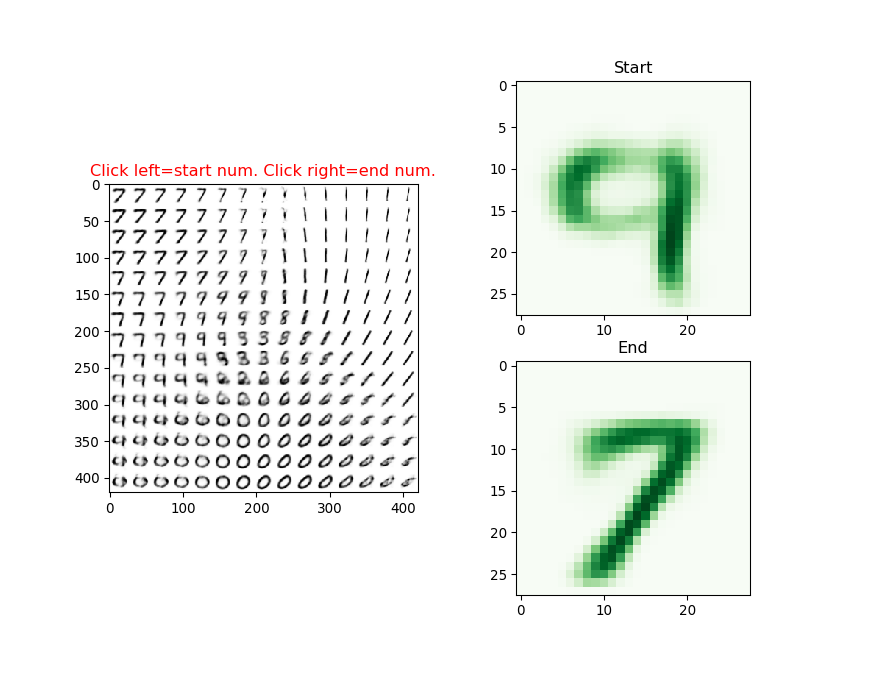

interactive(children=(FloatSlider(value=0.5, description='連續圖:', max=1.0, step=0.02), Output()), _dom_classes=…

<function __main__.inBetween(t)>

In [22]:
%matplotlib notebook

#設立畫布
plt.figure(figsize = (9, 7))
ax = plt.subplot(1, 2, 1)
plt.title('Click left=start num. Click right=end num.',fontsize=12,color='r')
ax10 = plt.subplot(2, 2, 2)
plt.title('Start')
ax20 = plt.subplot(2, 2, 4)
plt.title('End')

ax.imshow(VAE_figure, cmap='Greys')

#初始值
c_start = [[1,1],[200,200]]
c_end = [[200,200],[1,1]]

plt.gcf().canvas.mpl_connect('button_press_event', lambda event: onclick(event, ax))
interact(inBetween, t = FloatSlider(value=0.5, min=0, max=1.0, step=0.02,description = '連續圖:',),)
